In [22]:
import numpy as np
import cv2

# Define the path to the labeled videos and corresponding label files
labels_path = '../folder/label_14/'

# Define the number of frames in each video (assumed to be the same for all videos)
num_frames = 1200

# nparay for all angles
angles_labeled = []

# frames
frames = []

# Initialize an array to store the pitch and yaw angles for each frame
# angles = np.zeros((num_frames * 5, 2))
angles = []

# Load the labeled videos and extract the pitch and yaw angles for each frame
for i in range(4):

    # Load the label file
    labels = np.loadtxt(labels_path + str(i) + '.txt')

    lenght_label = len(labels)
    diff_lenght = num_frames - lenght_label

    # Iterate over each frame in the video
    for j in range(lenght_label):

        # Estimate the pitch and yaw angles for the current frame using the labels
        pitch = labels[j, 0]
        yaw = labels[j, 1]

        angles.append((pitch,yaw))
    
    if diff_lenght > 0:
        for k in range(diff_lenght):
            angles.append((None,None))
        

    # Print the shape of the angles array for verification
    #print(f"Angles shape for video {i}: {angles.shape}")

# Convert the list of frames to a numpy array
angles_array_labeled = np.array(angles, dtype = np.float32)
print(f"Frames shape for video : {angles_array_labeled.shape}")
#print(angles_array_labeled[0][0])

Frames shape for video : (4800, 2)


In [17]:
import cv2
file_path = "../folder/label_14/0.hevc"  # change to your own video path
vid = cv2.VideoCapture(file_path)
height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
width = vid.get(cv2.CAP_PROP_FRAME_WIDTH)
print(height/5, width/5)

174.8 232.8


## Preprocess and normalize function for a frame

In [18]:
import cv2
import numpy as np

# Define the desired width and height of the frames after resizing
width = 233
height = 175


# Define the intrinsic camera matrix
K = np.array([[910, 0, 0],
              [0, 910, 0],
              [0, 0, 1]])

# Define a function to preprocess a frame
def preprocess_frame(frame):
    # Undistort the frame using the intrinsic camera matrix
    undistorted_frame = cv2.undistort(frame, K, None)

    # Resize the frame to the desired dimensions
    resized_frame = cv2.resize(undistorted_frame, (width, height))

    # grayscale image
    #resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2GRAY)

    # bgr
    #resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2BGR)

    # HSV
    resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2HSV)
    # V value = 0
    resized_frame[..., 2] = resized_frame[..., 2] * 0

    # Convert the frame to float32 data type
    normalized_frame = resized_frame.astype(np.float32)

    # Normalize the frame using the defined mean and standard deviation
    normalized_frame /= 255.0

    return normalized_frame

# Labeled Frame

* En liste

In [23]:
# Define the path to the labeled videos
videos_path = '../folder/label_14/'


# Define the number of frames in each video (assumed to be the same for all videos)
num_frames = 1200

# Define a default frame to use for filling in missing frames
default_frame = np.zeros((height, width, 3), dtype=np.float32)

# Initialize a list to store the frames for each video
frames_list = []

# Iterate over each video
for i in range(4):
    # Load the video
    video = cv2.VideoCapture(videos_path + str(i) + '.hevc')

    # Initialize an empty list to store the frames for the current video
    frames = []

    # Iterate over each frame in the video
    for j in range(num_frames):
        # Read the frame
        ret, frame = video.read()

        # Check if the frame was successfully read
        if not ret:
            # If the frame was not read, use the default frame instead
            frame = default_frame

        frame = preprocess_frame(frame)
        
        # Append the frame to the list of frames for the current video
        #frames.append(frame)
        frames_list.append(frame)

    # Release the video object
    video.release()


    # Convert the list of frames to a numpy array
    frames_array_labeled = np.array(frames_list)
    print(f"Frames shape for video {i}: {frames_array_labeled.shape}")

# Convert the list of frames to a numpy array
frames_array_labeled = np.array(frames_list)
print(f"Frames shape for video : {frames_array_labeled.shape}")


# Print the shape of the frames list for verification
print(f"Frames shape: {len(frames_list)} videos, {len(frames_list[0])} frames per video, {len(frames_list[0])}x{len(frames_list[0][0])} pixels")


Frames shape for video 0: (1200, 175, 233, 3)
Frames shape for video 1: (2400, 175, 233, 3)
Frames shape for video 2: (3600, 175, 233, 3)
Frames shape for video 3: (4800, 175, 233, 3)
Frames shape for video : (4800, 175, 233, 3)
Frames shape: 4800 videos, 175 frames per video, 175x233 pixels


* Delete NaN values

In [24]:
# Find the indices where either pitch or yaw angle is nan
nan_idx = np.where(np.isnan(angles_array_labeled[:,0]) | np.isnan(angles_array_labeled[:,1]))

# Delete the corresponding rows from frames_array_labeled and angles_array_labeled
frames_array_labeled = np.delete(frames_array_labeled, nan_idx, axis=0)
angles_array_labeled = np.delete(angles_array_labeled, nan_idx, axis=0)

# Print the shape of the frames and angles arrays after removing NaN values
print(f"Frames shape: {frames_array_labeled.shape}")
print(f"Angles shape: {angles_array_labeled.shape}")

Frames shape: (3819, 175, 233, 3)
Angles shape: (3819, 2)


* Plot some frames

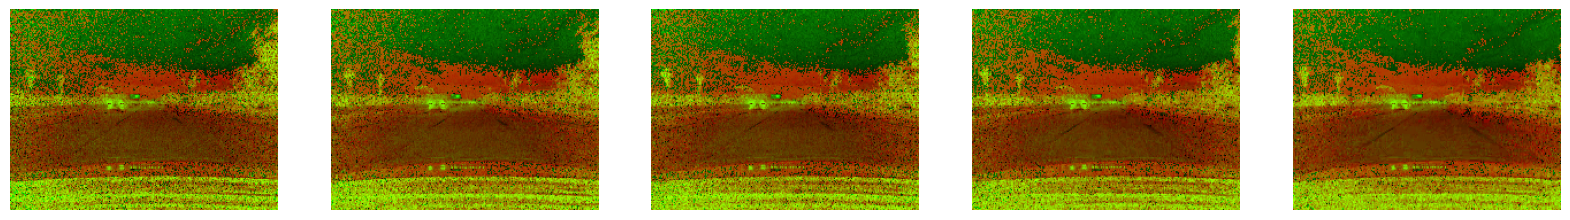

In [25]:
import matplotlib.pyplot as plt

# Define the number of frames to plot
num_frames_to_plot = 5

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, num_frames_to_plot, figsize=(20, 10))

# Plot the first num_frames_to_plot frames from the list
for i in range(num_frames_to_plot):
    axes[i].imshow(frames_list[i])
    axes[i].axis('off')

# Show the plot
plt.show()

* Get width height initial video 

# Convolutional neural network (CNN)

* classic

In [30]:
from tensorflow import keras

# Define the input shape of the frames (assumed to be the same for all frames)
input_shape = (height, width, 3)

# Define the number of output nodes (2 for pitch and yaw)
num_outputs = 2

# Define the CNN model
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_outputs, activation='linear')
])

# Compile the model with the mean squared error loss and the Adam optimizer
#model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#loss='mse', optimizer='adam', metrics=['mae']
# model.compile(
#     optimizer=keras.optimizers.RMSprop(),  # Optimizer
#     # Loss function to minimize
#     loss=keras.losses.SparseCategoricalCrossentropy(),
#     # List of metrics to monitor
#     metrics=[keras.metrics.SparseCategoricalAccuracy()],
# )



In [38]:
from keras.layers import Input, Dense, Convolution2D, Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import ZeroPadding2D, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.models import Model
import tensorflow as tf


with tf.device('/GPU:0'):
    input = Input(shape=(height, width, 3))
    
    conv1 = Conv2D(64,(7,7),strides=(2,2), padding='same',activation='relu',name='conv1')(input)
    pool1 = MaxPooling2D(pool_size=(3,3),strides=(2,2), padding='same',name='pool1')(conv1)
    norm1 = BatchNormalization(axis=3, name='norm1')(pool1)
    reduction2 = Conv2D(64,(1,1), padding='same',activation='relu',name='reduction2')(norm1)
    conv2 = Conv2D(192,(3,3),padding='same',activation='relu',name='conv2')(reduction2)
    norm2 = BatchNormalization(axis=3, name='norm2')(conv2)
    pool2 = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid',name='pool2')(norm2)
    icp1_reduction1 = Conv2D(96,(1,1),padding='same',activation='relu',name='icp1_reduction1')(pool2)
    icp1_out1 = Conv2D(128,(3,3),padding='same',activation='relu',name='icp1_out1')(icp1_reduction1)
    icp1_reduction2 = Conv2D(16,(1,1),padding='same',activation='relu',name='icp1_reduction2')(pool2)
    icp1_out2 = Conv2D(32,(5,5),padding='same',activation='relu',name='icp1_out2')(icp1_reduction2)
    icp1_pool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same',name='icp1_pool')(pool2)
    icp1_out3 = Conv2D(32,(1,1),padding='same',activation='relu',name='icp1_out3')(icp1_pool)
    icp1_out0 = Conv2D(64,(1,1),padding='same',activation='relu',name='icp1_out0')(pool2)
    icp2_in = concatenate([icp1_out0, icp1_out1, icp1_out2, icp1_out3], axis=-1)

    icp2_reduction1 = Conv2D(128,(1,1),padding='same',activation='relu',name='icp2_reduction1')(icp2_in)
    icp2_out1 = Conv2D(192,(3,3),padding='same',activation='relu',name='icp2_out1')(icp2_reduction1)
    icp2_reduction2 = Conv2D(32,(1,1),padding='same',activation='relu',name='icp2_reduction2')(icp2_in)
    icp2_out2 = Conv2D(96,(5,5),padding='same',activation='relu',name='icp2_out2')(icp2_reduction2)
    icp2_pool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same',name='icp2_pool')(icp2_in)
    icp2_out3 = Conv2D(64,(1,1),padding='same',activation='relu',name='icp2_out3')(icp2_pool)
    icp2_out0 = Conv2D(128,(1,1),padding='same',activation='relu',name='icp2_out0')(icp2_in)
    icp2_out = concatenate([icp2_out0, icp2_out1, icp2_out2, icp2_out3], axis=-1)

    icp3_in = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',name='icp3_in')(icp2_out)
    icp3_reduction1 = Conv2D(96,(1,1),padding='same',activation='relu',name='icp3_reduction1')(icp3_in)
    icp3_out1 = Conv2D(208,(3,3),padding='same',activation='relu',name='icp3_out1')(icp3_reduction1)
    icp3_reduction2 = Conv2D(16,(1,1),padding='same',activation='relu',name='icp3_reduction2')(icp3_in)
    icp3_out2 = Conv2D(48,(5,5),padding='same',activation='relu',name='icp3_out2')(icp3_reduction2)
    icp3_pool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same',name='icp3_pool')(icp3_in)
    icp3_out3 = Conv2D(64,(1,1),padding='same',activation='relu',name='icp3_out3')(icp3_pool)
    icp3_out0 = Conv2D(192,(1,1),padding='same',activation='relu',name='icp3_out0')(icp3_in)
    icp3_out = concatenate([icp3_out0, icp3_out1, icp3_out2, icp3_out3], axis = -1)

    cls1_pool = AveragePooling2D(pool_size=(5,5),strides=(3,3),padding='valid',name='cls1_pool')(icp3_out)
    cls1_reduction_speed = Conv2D(128,(1,1),padding='same',activation='relu',name='cls1_reduction_speed')(cls1_pool)
    cls1_fc1_flat = Flatten()(cls1_reduction_speed)    

    # Dedicate dense layer for each axis
    cls1_branch1_speed = Dense(1024,activation='relu',name='cls1_branch1_speed')(cls1_fc1_flat)
    cls1_branch2_speed = Dense(1024,activation='relu',name='cls1_branch2_speed')(cls1_fc1_flat)

    # Layer for each axis (1 neuron layer)
    pitch = Dense(1,name='pitch')(cls1_branch1_speed)
    yaw = Dense(1,name='yaw')(cls1_branch2_speed)
    
    model = Model(inputs=input, outputs=[pitch, yaw])

    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [63]:
from keras.layers import Input, Dense, Convolution2D, Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import ZeroPadding2D, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.models import Model
import tensorflow as tf

# Define the input shape of the frames (assumed to be the same for all frames)
input_shape = (height, width, 3)

# Define the number of output nodes (2 for pitch and yaw)
num_outputs = 2

# Define the CNN model
model = keras.Sequential([
    Conv2D(64,(7,7),strides=(2,2), padding='same',activation='relu',name='conv1', input_shape=input_shape),
    MaxPooling2D(pool_size=(3,3),strides=(2,2), padding='same',name='pool1'),
    BatchNormalization(axis=3, name='norm1'),
    Conv2D(64,(1,1), padding='same',activation='relu',name='reduction2'),
    Conv2D(192,(3,3),padding='same',activation='relu',name='conv2'),
    BatchNormalization(axis=3, name='norm2'),
    MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid',name='pool2'),
    Conv2D(96,(1,1),padding='same',activation='relu',name='icp1_reduction1'),
    Conv2D(128,(3,3),padding='same',activation='relu',name='icp1_out1'),
    Conv2D(16,(1,1),padding='same',activation='relu',name='icp1_reduction2'),
    Conv2D(32,(5,5),padding='same',activation='relu',name='icp1_out2'),
    MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same',name='icp1_pool'),
    Conv2D(32,(1,1),padding='same',activation='relu',name='icp1_out3'),
    Conv2D(64,(1,1),padding='same',activation='relu',name='icp1_out0'),

    Conv2D(128,(1,1),padding='same',activation='relu',name='icp2_reduction1'),
    Conv2D(192,(3,3),padding='same',activation='relu',name='icp2_out1'),
    Conv2D(32,(1,1),padding='same',activation='relu',name='icp2_reduction2'),
    Conv2D(96,(5,5),padding='same',activation='relu',name='icp2_out2'),
    MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same',name='icp2_pool'),
    Conv2D(64,(1,1),padding='same',activation='relu',name='icp2_out3'),
    Conv2D(128,(1,1),padding='same',activation='relu',name='icp2_out0'),
    
    MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',name='icp3_in'),
    Conv2D(96,(1,1),padding='same',activation='relu',name='icp3_reduction1'),
    Conv2D(208,(3,3),padding='same',activation='relu',name='icp3_out1'),
    Conv2D(16,(1,1),padding='same',activation='relu',name='icp3_reduction2'),
    Conv2D(48,(5,5),padding='same',activation='relu',name='icp3_out2'),
    MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same',name='icp3_pool'),
    Conv2D(64,(1,1),padding='same',activation='relu',name='icp3_out3'),
    Conv2D(192,(1,1),padding='same',activation='relu',name='icp3_out0'),

    AveragePooling2D(pool_size=(5,5),strides=(3,3),padding='valid',name='cls1_pool'),
    Conv2D(128,(1,1),padding='same',activation='relu',name='cls1_reduction_speed'),
    Flatten(),    

    # Dedicate dense layer for each axis
    Dense(1024,activation='relu',name='cls1_branch1_speed'),
    Dense(1024,activation='relu',name='cls1_branch2_speed'),

    # Layer for each axis (1 neuron layer)
    Dense(2,activation='linear')
])

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 88, 117, 64)       9472      
                                                                 
 pool1 (MaxPooling2D)        (None, 44, 59, 64)        0         
                                                                 
 norm1 (BatchNormalization)  (None, 44, 59, 64)        256       
                                                                 
 reduction2 (Conv2D)         (None, 44, 59, 64)        4160      
                                                                 
 conv2 (Conv2D)              (None, 44, 59, 192)       110784    
                                                                 
 norm2 (BatchNormalization)  (None, 44, 59, 192)       768       
                                                                 
 pool2 (MaxPooling2D)        (None, 21, 29, 192)      

# Replace NaN by 0

In [9]:
# has_nan = np.isnan(angles_array_labeled).any()
# if has_nan:
#     print("The array contains NaN values.")
# else:
#     print("The array does not contain NaN values.")


has_nan = np.isnan(angles_array_labeled).any()
if has_nan:
    print("The array contains NaN values.")
else:
    print("The array does not contain NaN values.")
    
angles_array_labeled = np.nan_to_num(angles_array_labeled, nan=0)

has_nan = np.isnan(angles_array_labeled).any()
if has_nan:
    print("The array contains NaN values.")
else:
    print("The array does not contain NaN values.")

print("dtype frames", frames_array_labeled.dtype)
print("dtype angles", angles_array_labeled.dtype)

The array does not contain NaN values.
The array does not contain NaN values.
dtype frames float32
dtype angles float32


# Train

* GPU

In [65]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# frees up any memory that was used during last session
tf.keras.backend.clear_session()

# Split the labeled video data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(frames_array_labeled, angles_array_labeled, test_size=0.2, random_state=1)

# Define data augmentation parameters
#data_gen = ImageDataGenerator(brightness_range=(0.75, 1))

# Generate augmented images
#augmented_images = data_gen.flow(x_train, y_train, batch_size=32)

# Train the model on the training set using the fit() function and evaluate it with evaluate()
with tf.device('/GPU:0'):
    history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val, y_val))
    loss = model.evaluate(x_val, y_val)
print('Validation Loss:', loss)

Epoch 1/100
96/96 [==============================] - 7s 53ms/step - loss: 2.3799e-04 - accuracy: 0.6092 - val_loss: 1.8853e-04 - val_accuracy: 0.5812
Epoch 2/100
96/96 [==============================] - 4s 44ms/step - loss: 1.3228e-04 - accuracy: 0.7610 - val_loss: 2.9230e-04 - val_accuracy: 0.5812
Epoch 3/100
96/96 [==============================] - 4s 45ms/step - loss: 1.1965e-04 - accuracy: 0.7836 - val_loss: 2.2769e-04 - val_accuracy: 0.5812
Epoch 4/100
96/96 [==============================] - 4s 45ms/step - loss: 1.2022e-04 - accuracy: 0.7764 - val_loss: 8.0334e-05 - val_accuracy: 0.7003
Epoch 5/100
96/96 [==============================] - 4s 44ms/step - loss: 1.1754e-04 - accuracy: 0.7971 - val_loss: 6.3065e-05 - val_accuracy: 0.8678
Epoch 6/100
96/96 [==============================] - 4s 44ms/step - loss: 1.1770e-04 - accuracy: 0.7787 - val_loss: 6.5205e-05 - val_accuracy: 0.8717
Epoch 7/100
96/96 [==============================] - 4s 45ms/step - loss: 1.1411e-04 - accuracy: 0.7

KeyboardInterrupt: 

* Plot

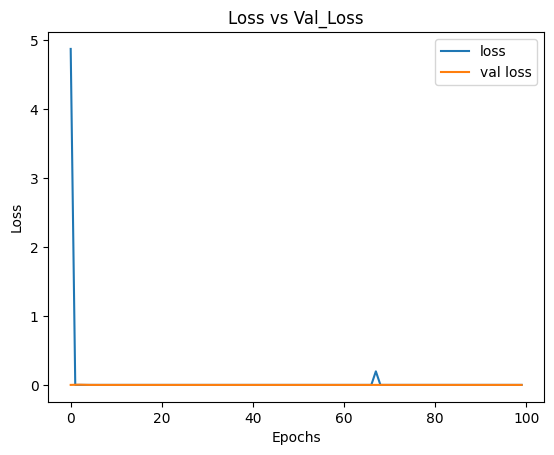

KeyError: 'accuracy'

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title("accuracy vs Val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

# Predict

* Predict for label videos and save files

In [54]:
import numpy as np

# Define the path to the labeled videos
videos_path = '../labeled/'

# Define the path to the output files
output_path = '../folder/'

# Define the dimensions of the frames (assumed to be the same for all videos)
frame_width = 1920
frame_height = 1080

# Define the number of frames in each video (assumed to be the same for all videos)
num_frames = 1200

# file
i = 1

# Initialize arrays to store the predicted pitch and yaw angles for each frame in each video
pitch_angles = np.zeros((5, num_frames))
yaw_angles = np.zeros((5, num_frames))


# Load the video
video = cv2.VideoCapture(videos_path + str(i) + '.hevc')

# Initialize an empty list to store the frames for the current video
frames = []

# Iterate over each frame in the video
for j in range(num_frames):
    # Read the frame
    ret, frame = video.read()

    # Check if the frame was successfully read
    if not ret:
        break

    # Preprocess the frame
    frame = preprocess_frame(frame)

    # Make a prediction using the model
    prediction = model.predict(np.expand_dims(frame, axis=0))

    npprediction = np.array(prediction)
    print(npprediction.shape)
    # Extract the pitch and yaw angles from the prediction
    pitch_angle = prediction[0]
    yaw_angle = prediction[1]   

    # Store the pitch and yaw angles in the arrays
    pitch_angles[i, j] = pitch_angle
    yaw_angles[i, j] = yaw_angle

# Release the video object
video.release()

# Write the pitch and yaw angles to files
np.savetxt(output_path + str(i) + '.txt', np.vstack((pitch_angles[i], yaw_angles[i])).T)


1/1 [==============================] - 0s 24ms/step
(2, 1, 1)


ValueError: not enough values to unpack (expected 2, got 1)

* Plot my generated angles

In [13]:
import numpy as np

# Define the path to the labeled videos and corresponding label files
labels_path = '../folder/'

# Define the number of frames in each video (assumed to be the same for all videos)
num_frames = 1200

# nparay for all angles
angles_predicted_labeled = []
angles_initial_labeled = []

# frames
frames = []

# Initialize an array to store the pitch and yaw angles for each frame
angles = []
i = 1

########################### predicted ###########################

# Load the predicted label file
labels = np.loadtxt(labels_path + str(i) + '.txt')

lenght_label = len(labels)
diff_lenght = num_frames - lenght_label

# Iterate over each frame in the video
for j in range(lenght_label):

    # Estimate the pitch and yaw angles for the current frame using the labels
    pitch = labels[j, 0]
    yaw = labels[j, 1]

    angles.append((pitch,yaw))

if diff_lenght > 0:
    for k in range(diff_lenght):
        angles.append((None,None))

# Convert the list of frames to a numpy array
angles_predicted_labeled = np.array(angles, dtype = np.float32)
print(f"Frames shape for video predicted : {angles_predicted_labeled.shape}")

########################### Labeled ###########################

labels_path = '../labeled/'
angles = []
frames = []
# Load the inital label file
labels = np.loadtxt(labels_path + str(i) + '.txt')

lenght_label = len(labels)
diff_lenght = num_frames - lenght_label

# Iterate over each frame in the video
for j in range(lenght_label):

    # Estimate the pitch and yaw angles for the current frame using the labels
    pitch = labels[j, 0]
    yaw = labels[j, 1]

    angles.append((pitch,yaw))

if diff_lenght > 0:
    for k in range(diff_lenght):
        angles.append((None,None))

# Convert the list of frames to a numpy array
angles_initial_labeled = np.array(angles, dtype = np.float32)
print(f"Frames shape for video labeled : {angles_initial_labeled.shape}")

# Find the indices of the rows containing NaN values in the first and second columns
nan_idx_0 = np.isnan(angles_initial_labeled[:,0])
nan_idx_1 = np.isnan(angles_initial_labeled[:,1])
# Replace the values in the first and second columns with NaN
angles_predicted_labeled[nan_idx_0,0] = np.nan
angles_predicted_labeled[nan_idx_1,1] = np.nan

# Print the shape of the frames and angles arrays after removing NaN values
print(f"Angles predicted: {angles_predicted_labeled.shape}")
print(f"Angles initial: {angles_initial_labeled.shape}")

Frames shape for video predicted : (1200, 2)
Frames shape for video labeled : (1200, 2)
Angles predicted: (1200, 2)
Angles initial: (1200, 2)


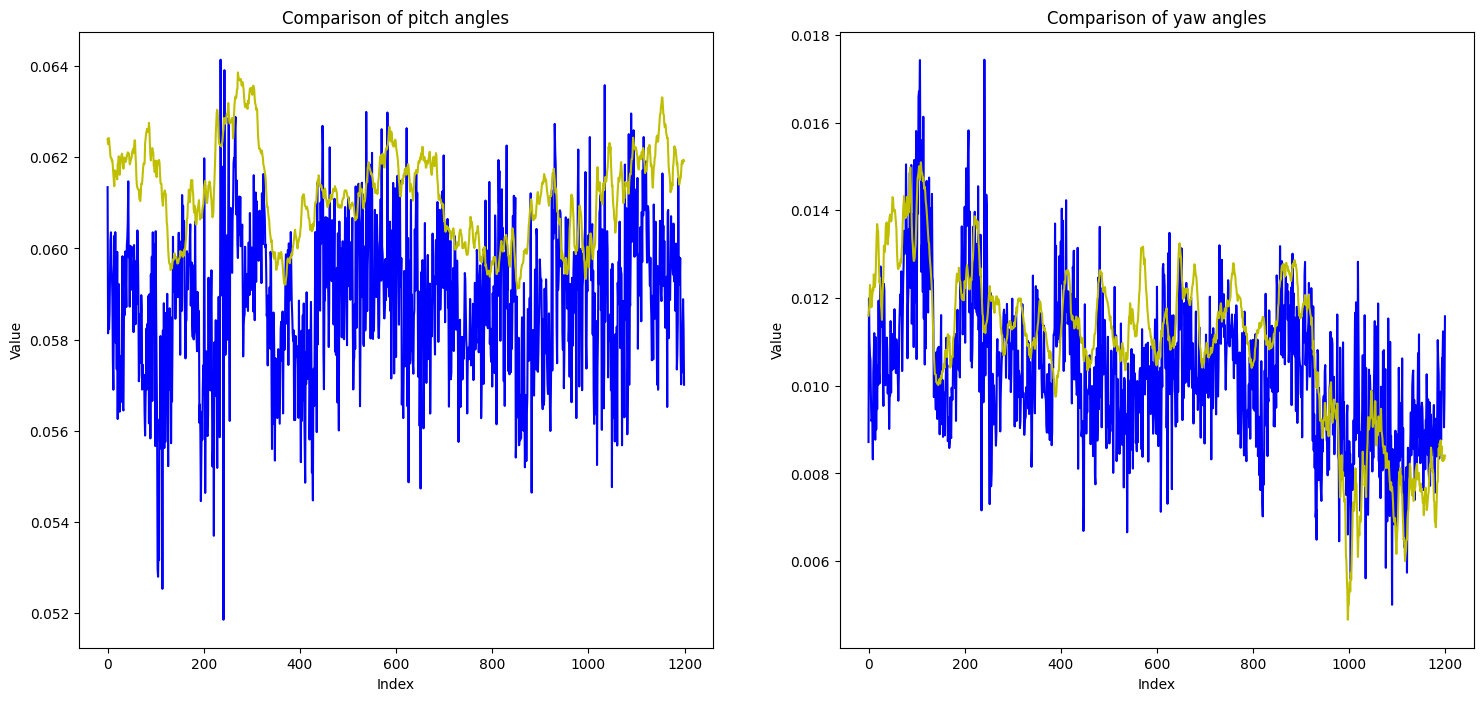

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Define two NumPy arrays for comparison
array1_pitch = angles_predicted_labeled[:, 0]
array2_pitch = angles_initial_labeled[:, 0]

# Plot the two arrays with different colors in the first subplot
ax1.plot(array1_pitch, 'b')
ax1.plot(array2_pitch, 'y')

# Add title and labels for the first subplot
ax1.set_title('Comparison of pitch angles')
ax1.set_xlabel('Index')
ax1.set_ylabel('Value')

# Define two NumPy arrays for comparison
array1_yaw = angles_predicted_labeled[:, 1]
array2_yaw = angles_initial_labeled[:, 1]

# Plot the two arrays with different colors in the second subplot
ax2.plot(array1_yaw, 'b')
ax2.plot(array2_yaw, 'y')

# Add title and labels for the second subplot
ax2.set_title('Comparison of yaw angles')
ax2.set_xlabel('Index')
ax2.set_ylabel('Value')

# Show the plot
plt.show()

* Predict for unlabeled videos and save files

In [15]:
import numpy as np

# Define the path to the unlabeled videos
videos_path = 'C:/Users/youss/Desktop/Youssef/Stage2/Tests/calib_challenge-main/unlabeled/'

# Define the path to the output files
output_path = 'C:/Users/youss/Desktop/Youssef/Stage2/Tests/calib_challenge-main/folder/outputs/'

# Define the dimensions of the frames (assumed to be the same for all videos)
frame_width = 1920
frame_height = 1080

# Define the number of frames in each video (assumed to be the same for all videos)
num_frames = 1200

# Initialize arrays to store the predicted pitch and yaw angles for each frame in each video
pitch_angles = np.zeros((5, num_frames))
yaw_angles = np.zeros((5, num_frames))

# Iterate over each video
for i in range(5):
    # Load the video
    video = cv2.VideoCapture(videos_path + str(i + 5) + '.hevc')

    # Initialize an empty list to store the frames for the current video
    frames = []

    # Iterate over each frame in the video
    for j in range(num_frames):
        # Read the frame
        ret, frame = video.read()

        # Check if the frame was successfully read
        if not ret:
            break

        # Preprocess the frame
        frame = preprocess_frame(frame)

        # Make a prediction using the model
        prediction = model.predict(np.expand_dims(frame, axis=0))

        # Extract the pitch and yaw angles from the prediction
        pitch_angle, yaw_angle = prediction[0]

        # Store the pitch and yaw angles in the arrays
        pitch_angles[i, j] = pitch_angle
        yaw_angles[i, j] = yaw_angle

    # Release the video object
    video.release()

    # Write the pitch and yaw angles to files
    np.savetxt(output_path + str(i + 5) + '.txt', np.vstack((pitch_angles[i], yaw_angles[i])).T)


1/1 [==============================] - 0s 28ms/step


In [16]:
Your plan looks like a good starting point for generating the labels for the unlabeled videos. Here are a few comments on your approach:

1- Loading the labeled videos and extracting the pitch and yaw angles for each frame is a good first step. This will provide you with the training data you need to train your model.

2- Loading the unlabeled videos and extracting the frames is also a good next step.

3- Preprocessing the frames by resizing and normalizing them is a good idea, as this can help improve the accuracy of your model.

4- Building a neural network model that takes in a frame and outputs the estimated pitch and yaw angles is a good approach. You may want to consider using a convolutional neural network (CNN) to learn features from the images, as this can be effective for image-based tasks.

5- Training the model using the labeled video data and evaluating its performance is essential to ensure that your model is accurate and effective. You may want to use metrics such as mean squared error (MSE) or mean absolute error (MAE) to evaluate the performance of your model.

6- Using the trained model to predict the pitch and yaw angles for each frame in the unlabeled videos is a good next step.

7- Saving the predicted pitch and yaw angles in 2D arrays and writing them to files 5.txt to 9.txt is a good final step.

Overall, your plan looks like a good approach to generate the labels for the unlabeled videos. Just keep in mind that it may require some iteration and adjustment based on your results. Good luck with your project!





SyntaxError: invalid syntax (2018567734.py, line 1)